[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/Xee/blob/main/docs/client-vs-server.ipynb)


# Client vs. Server

**When you use Xee, you have to decide where to run your computations: on the Earth Engine servers or locally on the client**. Your decision will depend on the relative importance of performance, flexibility, code readability, and process control (and if you're a commercial EE user, cost). If you're unfamiliar with Earth Engine, a helpful analogy is working with a relational database and pandas: just as you might choose between SQL operations in the database versus pandas operations in your application, with Xee you can perform calculations either on Earth Engine's servers or locally with Xarray.

**Like database operations, the key tradeoff is between processing at the data source versus locally after download**. Earth Engine can efficiently process global-scale data but limits you to its built-in operations, while local processing gives you full Python flexibility but requires downloading the data first.

For best results, follow this general workflow: first reduce your data as much as practical using Earth Engine's built-in operations, then transfer the reduced dataset to your local environment for further analysis or visualization. **Earth Engine excels at common geospatial operations like**:

- Temporal aggregation (annual means, monthly totals)
- Spatial reductions (regional averages, zonal statistics)
- Band math and basic calculations
- Filtering and masking
- Band selection
- Resampling and reprojecting

Once you've reduced your data to a manageable size, use Xee to transfer it locally where you can **leverage Xarray and the broader Python ecosystem for**:

- Custom calculations
- Interactive analysis
- Complex statistics
- Interoperability with other datasets
- Publication-quality visualization

This approach minimizes data transfer while maximizing flexibility. Think of it like using SQL to filter and aggregate your data before pulling it into pandas for final analysis.

## Examples

When working with Earth Engine via Xee, deciding where to run computations—on Earth Engine's servers or locally—involves considering performance, flexibility, and code readability. To illustrate these trade-offs, let's consider analyzing 60 years of monthly aggregated ERA5 temperature data (1-degree pixels), calculating the following metrics: the time series mean, the slope of July temperature over the time series, and the monthly mean difference across the time series.

In [155]:
# Install Xee if using Colab.
#!pip install -q xee
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 50.5 MB/s eta 0:00:00


In [196]:
import ee
import xarray
import  matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rioxarray # Required for clipping operations
from shapely.geometry import Polygon # To define a polygon for clipping
import geopandas as gpd
from scipy.signal import savgol_filter # Added for Savitzky-Golay smoothing

In [3]:
ee.Authenticate()
ee.Initialize(project='ee-gabibessel',
              opt_url='https://earthengine-highvolume.googleapis.com'
              ) # Edit for your Cloud project ID

### Time series mean

#### Client-side computation (using Xarray)

To perform this client-side, we first retrieve all 720 monthly images from the ERA5 dataset using Xee. Then, using Xarray, we calculate the mean across the time dimension. This approach offers the full flexibility of the Python ecosystem; however, it requires transferring a substantial amount of data (720 images) to the client. The Xarray code for this is concise and readable, leveraging Xarray's built-in `mean()` function.

In [13]:
climate = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
    .filterDate('1960', '2020'))

In [191]:
#
#point_lat, point_lon =  41.698320,  -4.710212 #Itacyl Castilla León - Valladolid
point_lat, point_lon =   39.053708,   -2.106626 # Barrax, Spain Production Area

aoi = ee.Geometry.Point([point_lon, point_lat]) # Area of interest central point
roi = ee.Geometry.Rectangle([point_lon-0.025, point_lat-0.025, point_lon+0.025, point_lat+0.025]) # Region of interest

#
start_date, end_date = '2020-01-01', '2024-12-31' # time series range
CLOUD_FILTER = 60 # Cloudy pixel percentage

s2_sr_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(start_date, end_date).filterBounds(aoi).filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

In [115]:
#
projection = s2_sr_collection.first().select(0).projection().getInfo()['crs']
print(projection)

EPSG:32630


In [192]:
#
s2_resolution = 10 # Sentinel-2 spatial resolution

# Sentinel-2 surface reflectance dataset
s2_sr_ds = xarray.open_dataset(
    s2_sr_collection,
    engine='ee',
    scale=s2_resolution,
    crs = s2_sr_collection.first().select(0).projection().getInfo()['crs'],
    geometry=roi,
)

In [193]:
# Sentinel-2 surface reflectance dataset
s2_sr_ds

<xarray.Dataset> Size: 13GB
Dimensions:              (time: 507, X: 427, Y: 559)
Coordinates:
  * time                 (time) datetime64[ns] 4kB 2020-01-01T11:00:15.500000...
  * X                    (X) float64 3kB 5.752e+05 5.752e+05 ... 5.794e+05
  * Y                    (Y) float64 4kB 4.32e+06 4.32e+06 ... 4.326e+06
Data variables: (12/26)
    B1                   (time, X, Y) float32 484MB ...
    B2                   (time, X, Y) float32 484MB ...
    B3                   (time, X, Y) float32 484MB ...
    B4                   (time, X, Y) float32 484MB ...
    B5                   (time, X, Y) float32 484MB ...
    B6                   (time, X, Y) float32 484MB ...
    ...                   ...
    QA10                 (time, X, Y) float32 484MB ...
    QA20                 (time, X, Y) float32 484MB ...
    QA60                 (time, X, Y) float32 484MB ...
    MSK_CLASSI_OPAQUE    (time, X, Y) float32 484MB ...
    MSK_CLASSI_CIRRUS    (time, X, Y) float32 484MB ...
    MSK_CLASSI_SNOW_ICE  (time, X, Y) float32 484MB ...
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:32630

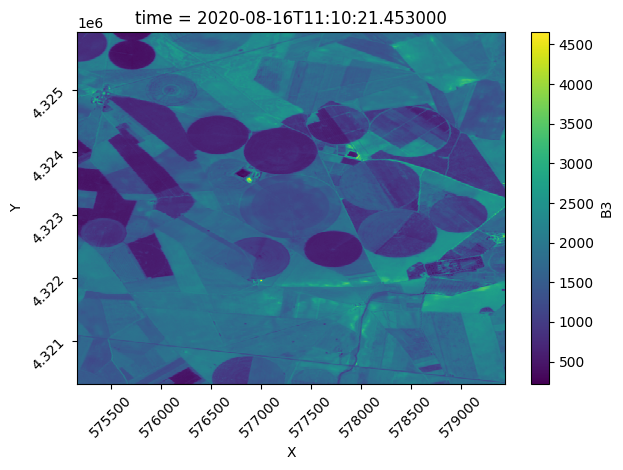

In [133]:
plot = s2_sr_ds['B3'].sel(time='2020-08-16').transpose().plot()
ax = plt.gca() # Get the current axes

# Rotate x-axis (longitude) ticks by 45 degrees
ax.tick_params(axis='x', labelrotation=45)

# Rotate y-axis (latitude) ticks by 90 degrees
ax.tick_params(axis='y', labelrotation=45)

# Important: Adjust spacing to prevent labels from overlapping
plt.tight_layout()  # Or manually adjust using plt.subplots_adjust()

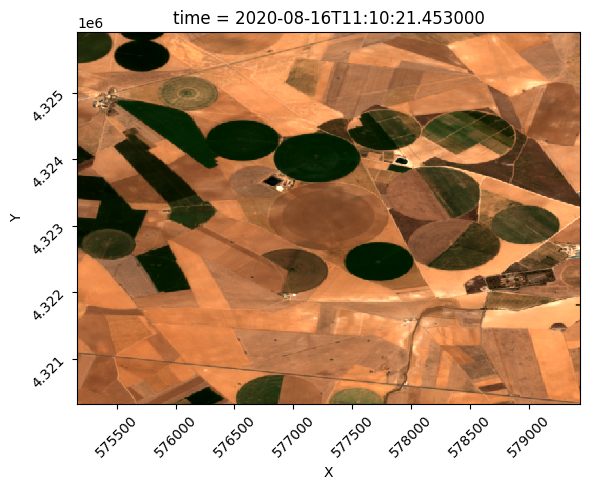

In [136]:
#
# Select the specific time slice and the RGB bands
# Then stack them into a new 'band' dimension, transpose to (y, x, band)
# and convert to a NumPy array, normalizing to 0-1 range.
rgb_data_array = s2_sr_ds[['B4', 'B3', 'B2']].sel(time='2020-08-16', method='nearest') \
                                  .to_array(dim='band') \
                                  .transpose('Y', 'X', 'band')

plot = rgb_data_array.sel(band = ['B4','B3','B2']).plot.imshow(robust=True,figsize=(6,5))
ax = plt.gca() # Get the current axes

# Rotate x-axis (longitude) ticks by 45 degrees
ax.tick_params(axis='x', labelrotation=45)

# Rotate y-axis (latitude) ticks by 90 degrees
ax.tick_params(axis='y', labelrotation=45)

# Important: Adjust spacing to prevent labels from overlapping
plt.tight_layout()  # Or manually adjust using plt.subplots_adjust()

plt.show()

In [141]:
#
s2_sr_roi_xr = s2_sr_ds #.sel(time='2023-04-03'),

s2_ndvi_roi_xr = s2_sr_roi_xr
s2_ndvi_roi_xr['ndvi'] = (s2_ndvi_roi_xr['B8'] - s2_ndvi_roi_xr['B4'])/\
                         (s2_ndvi_roi_xr['B8'] + s2_ndvi_roi_xr['B4'])

s2_ndvi_roi_xr

<xarray.Dataset> Size: 13GB
Dimensions:              (time: 507, X: 427, Y: 559)
Coordinates:
  * time                 (time) datetime64[ns] 4kB 2020-01-01T11:00:15.500000...
  * X                    (X) float64 3kB 5.752e+05 5.752e+05 ... 5.794e+05
  * Y                    (Y) float64 4kB 4.32e+06 4.32e+06 ... 4.326e+06
Data variables: (12/27)
    B1                   (time, X, Y) float32 484MB ...
    B2                   (time, X, Y) float32 484MB ...
    B3                   (time, X, Y) float32 484MB ...
    B4                   (time, X, Y) float32 484MB ...
    B5                   (time, X, Y) float32 484MB ...
    B6                   (time, X, Y) float32 484MB ...
    ...                   ...
    QA20                 (time, X, Y) float32 484MB ...
    QA60                 (time, X, Y) float32 484MB ...
    MSK_CLASSI_OPAQUE    (time, X, Y) float32 484MB ...
    MSK_CLASSI_CIRRUS    (time, X, Y) float32 484MB ...
    MSK_CLASSI_SNOW_ICE  (time, X, Y) float32 484MB ...
    ndvi                 (time, X, Y) float32 484MB 0.1258 0.1085 ... 0.006829
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:32630

In [145]:
colors = ["#8f2723", "#8f2723", "#8f2723", "#8f2723", "#af201b", "#af201b", "#af201b", "#af201b", "#ce4a2e", "#ce4a2e", "#ce4a2e", "#ce4a2e",
          "#df744a", "#df744a", "#df744a", "#df744a", "#f0a875", "#f0a875", "#f0a875", "#f0a875", "#fad398", "#fad398", "#fad398", "#fad398",
          "#fff8ba",
          "#d8eda0", "#d8eda0", "#d8eda0", "#d8eda0", "#bddd8a", "#bddd8a", "#bddd8a", "#bddd8a", "#93c669", "#93c669", "#93c669", "#93c669",
          "#5da73e", "#5da73e", "#5da73e", "#5da73e", "#3c9427", "#3c9427", "#3c9427", "#3c9427", "#235117", "#235117", "#235117", "#235117"]
cmap_ndvi = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
cmap_ndvi.set_over('#235117')
cmap_ndvi.set_under('#8f2723')

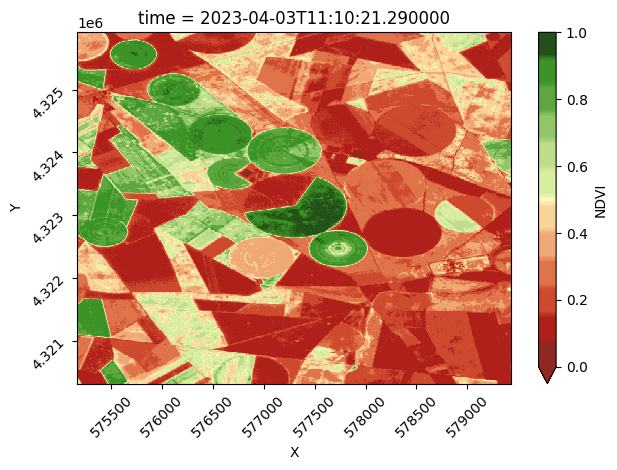

In [152]:
#
plot = s2_ndvi_roi_xr.sel(time='2023-04-03').ndvi.transpose().plot(vmin=0, vmax=1,cmap=cmap_ndvi,cbar_kwargs={"label": "NDVI"})

cbar = plot.colorbar
ax = plot.axes

# Rotate x-axis (longitude) ticks by 45 degrees
ax.tick_params(axis='x', labelrotation=45)

# Rotate y-axis (latitude) ticks by 90 degrees
ax.tick_params(axis='y', labelrotation=45)

# Important: Adjust spacing to prevent labels from overlapping
plt.tight_layout()  # Or manually adjust using plt.subplots_adjust()

plt.show()

In [190]:
print(crop_parcel_polygon_latlon)

POLYGON ((-2.109126 39.051208, -2.109126 39.056208, -2.104126 39.056208, -2.104126 39.051208, -2.109126 39.051208))



--- Generating NDVI Time Series for a Polygon ---
Setting spatial dimensions and CRS for rioxarray...
NDVI data clipped to polygon.
Mean NDVI calculated for each date.
<xarray.DataArray 'NDVI' (time: 507)> Size: 2kB
array([ 0.03200189,  0.08829496,  0.14519589,  0.12604515,  0.13492845,
        0.14745125,  0.13065827,  0.11259718,  0.13109778,  0.10808736,
        0.13765673,  0.13877171,  0.14369473,  0.11927696,  0.12655814,
        0.1361097 ,  0.1786659 ,  0.18609303,  0.18401062,  0.2051495 ,
        0.23673075,  0.23657872,  0.61094165,  0.7227451 ,  0.39593482,
        0.8670665 ,  0.8275888 ,  0.8877639 ,  0.8756868 ,  0.8509159 ,
        0.82038957,  0.8525476 ,  0.70316553,  0.5212645 ,  0.19219768,
        0.2747033 ,  0.24145232,  0.20454153,  0.18955328,  0.19566795,
        0.19424142,  0.18330167,  0.01051377,  0.1548425 ,  0.13917497,
        0.14120594,  0.13705876,  0.13519828,  0.10370795,  0.12954614,
        0.10526875,  0.10534978,  0.09925917,  0.12028842,  0.1

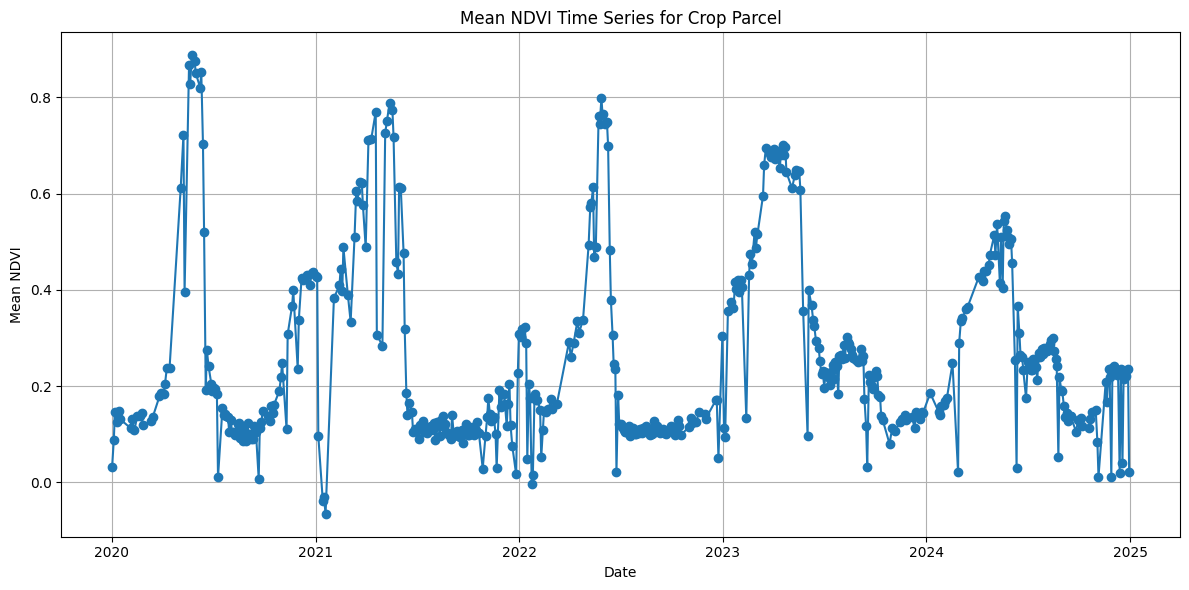

In [194]:
# --- NDVI Time Series Plotting for a Polygon ---
if s2_sr_ds is not None and 'time' in s2_sr_ds.dims and 'B4' in s2_sr_ds.data_vars and 'B8' in s2_sr_ds.data_vars:
    print("\n--- Generating NDVI Time Series for a Polygon ---")

    # 1. Calculate NDVI
    # Ensure to handle potential division by zero or very small numbers
    # Add a small epsilon to the denominator to prevent division by zero
    epsilon = 1e-6
    ndvi = (s2_sr_ds['B8'] - s2_sr_ds['B4']) / (s2_sr_ds['B8'] + s2_sr_ds['B4'] + epsilon)
    ndvi.name = 'NDVI' # Give the DataArray a name

    # 2. Define your polygon (crop parcel) in the same CRS as your dataset (EPSG:4326)
    # Example polygon coordinates (a small square within the loaded region over Spain)
    # Format: (lon, lat) for each vertex

    polygon_coords = [
        (point_lon-0.0025, point_lat-0.0025 ), # Bottom-left
        (point_lon-0.0025, point_lat+0.0025), # Top-left
        (point_lon+0.0025, point_lat+0.0025), # Top-right
        (point_lon+0.0025, point_lat-0.0025), # Bottom-right
        (point_lon-0.0025, point_lat-0.0025)  # Close the polygon
    ]
    # Create a shapely Polygon object
    crop_parcel_polygon_latlon = Polygon(polygon_coords)

    # Define the source CRS of your polygon
    polygon_source_crs = "EPSG:4326" # Polygon is defined in WGS84 Lat/Lon

    # Create a geopandas GeoSeries from the polygon coordinates with its source CRS
    gdf_polygon = gpd.GeoSeries([Polygon(crop_parcel_polygon_latlon)], crs=polygon_source_crs)
    gdf_polygon_reprojected = gdf_polygon.to_crs(s2_sr_collection.first().select(0).projection().getInfo()['crs'])
    crop_parcel_polygon = gdf_polygon_reprojected.geometry[0] # Get the shapely Polygon obje

    # 3. Clip the NDVI data to the polygon
    # rioxarray's clip_box or clip methods are useful here.
    # Ensure your xarray dataset has spatial dimensions recognized by rioxarray
    # (usually 'x' and 'y' with coordinate values)
    try:
        # Set spatial dimensions and CRS if not already set, needed for rioxarray
        if 'X' not in ndvi.dims or 'Y' not in ndvi.dims or not ndvi.rio.crs:
            print("Setting spatial dimensions and CRS for rioxarray...")
            # Assuming 'x' and 'y' are longitude and latitude respectively
            # and the CRS is already EPSG:4326 from xr.open_dataset
            ndvi = ndvi.rio.set_spatial_dims(x_dim='X', y_dim='Y')
            ndvi = ndvi.rio.write_crs(s2_sr_ds.rio.crs) # Use the CRS from the original dataset

        ndvi_clipped = ndvi.rio.clip([crop_parcel_polygon], ndvi.rio.crs, drop=True)
        print("NDVI data clipped to polygon.")

        # 4. Calculate the mean NDVI for the polygon for each date
        # Mean across the spatial dimensions ('x' and 'y')
        mean_ndvi_time_series = ndvi_clipped.mean(dim=['X', 'Y'])
        print("Mean NDVI calculated for each date.")
        print(mean_ndvi_time_series)

        # 5. Plot the time series
        plt.figure(figsize=(12, 6))
        mean_ndvi_time_series.plot(marker='o', linestyle='-')
        plt.title("Mean NDVI Time Series for Crop Parcel")
        plt.xlabel("Date")
        plt.ylabel("Mean NDVI")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during NDVI time series generation or plotting: {e}")
        print("Ensure 'rioxarray' is installed (`pip install rioxarray`) and your dataset has valid spatial coordinates.")
else:
    print("\nSkipping NDVI Time Series: Dataset not loaded, or missing 'time', 'B4', or 'B8' bands.")


NDVI time series smoothed using Savitzky-Golay (window=21, polyorder=5).


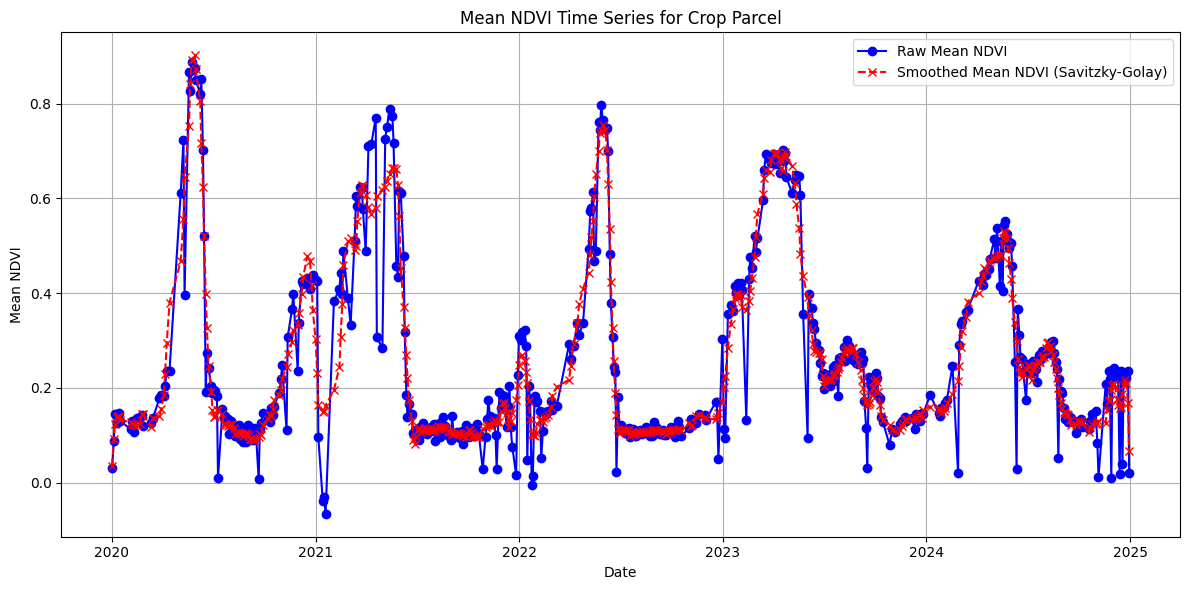

In [201]:
# 6. Apply Savitzky-Golay filter for smoothing
# window_length: must be odd.
# polyorder: must be less than window_length.
# Adjust these parameters based on your data's noise level and desired smoothness.
window_length = 21
polyorder = 5
if len(mean_ndvi_time_series) >= window_length:
      smoothed_ndvi_time_series = savgol_filter(mean_ndvi_time_series.values, window_length, polyorder)
      # Convert back to xarray DataArray for plotting consistency
      smoothed_ndvi_time_series = xarray.DataArray(
           smoothed_ndvi_time_series,
            coords=mean_ndvi_time_series.coords,
            dims=mean_ndvi_time_series.dims,
             name='Smoothed NDVI'
             )
      print(f"NDVI time series smoothed using Savitzky-Golay (window={window_length}, polyorder={polyorder}).")
else:
      print(f"Not enough data points ({len(mean_ndvi_time_series)}) for Savitzky-Golay filter with window_length={window_length}. Skipping smoothing.")
      smoothed_ndvi_time_series = None


# 7. Plot the time series (raw and smoothed)
plt.figure(figsize=(12, 6))
mean_ndvi_time_series.plot(marker='o', linestyle='-', label='Raw Mean NDVI', color='blue')
if smoothed_ndvi_time_series is not None:
   smoothed_ndvi_time_series.plot(marker='x', linestyle='--', label='Smoothed Mean NDVI (Savitzky-Golay)', color='red')
plt.title("Mean NDVI Time Series for Crop Parcel")
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Server-side computation (using Earth Engine)

Alternatively, we can perform the entire calculation on Earth Engine's servers. This involves a single call to Earth Engine's `mean()` reducer. The result is a single image representing the mean temperature over the entire time series, which is then downloaded. This dramatically reduces data transfer, leading to potentially significant performance gains, especially for larger datasets or higher spatial resolutions. The Earth Engine code is also quite readable, expressing the calculation in a clear and concise manner.



/usr/local/lib/python3.11/dist-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


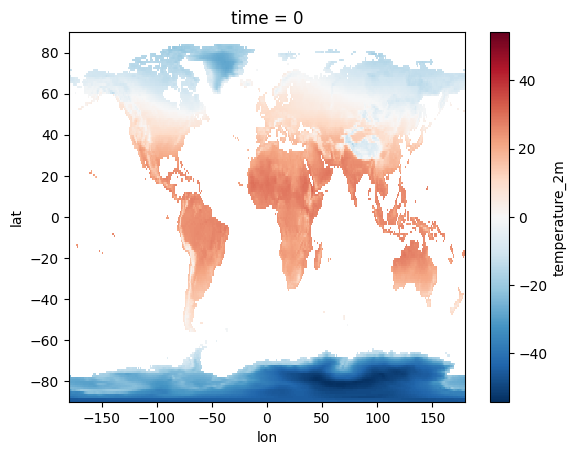

In [6]:
mean_deg_c = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
    .filterDate('1960', '2020')
    .select('temperature_2m')
    .mean()
    .subtract(273.15))

ds = xarray.open_dataset(
    ee.ImageCollection([mean_deg_c]),
    engine='ee',
    scale=1,
    crs='EPSG:4326',
    geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

ds['temperature_2m'].transpose().plot()

#### Comparison

In this specific case, the performance advantage of server-side computation, due to minimal data transfer, likely outweighs any potential benefits of client-side flexibility. Readability is comparable in both approaches.

### Simple linear regression (July trend)

#### Client-side computation (using Xarray)

To calculate the slope of July temperature over the time series client-side, we first download all 720 monthly images. We then filter for July data using Xarray's time accessor and calculate the slope using `polyfit`. This approach gives us the full flexibility of the Python ecosystem, allowing for complex pre- and post-processing. However, it requires transferring all 720 images, a substantial amount of data.

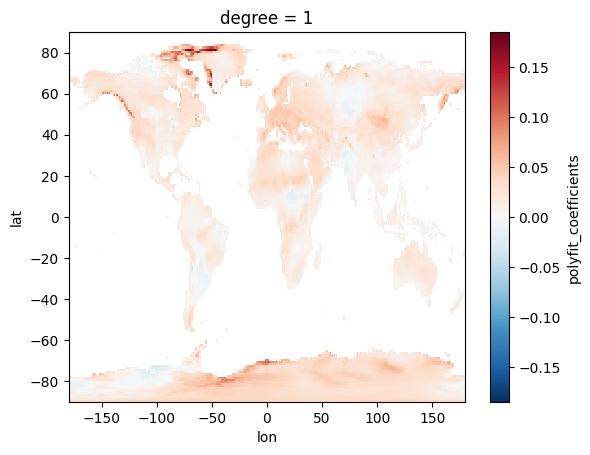

In [7]:
climate = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
   .filterDate('1960', '2020'))

ds = xarray.open_dataset(
   climate,
   engine='ee',
   scale=1,
   crs='EPSG:4326',
   geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

deg_c = ds['temperature_2m'] - 273.15
july_deg_c = deg_c.sel(time=deg_c.time.dt.month == 7)
july_deg_c['time_years'] = july_deg_c.time.dt.year - july_deg_c.time[0].dt.year
coeff = july_deg_c.polyfit(dim='time_years', deg=1)
slope = coeff['polyfit_coefficients'].sel(degree=1)
slope.transpose().plot()

#### Server-side computation (using Earth Engine)

With Earth Engine, we perform all computations on the server. We filter the collection for July, convert to Celsius, add a year band, and use `ee.Reducer.linearFit()` to efficiently calculate the slope. Only the resulting slope image is then downloaded. This drastically reduces data transfer compared to the client-side approach.

/usr/local/lib/python3.11/dist-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


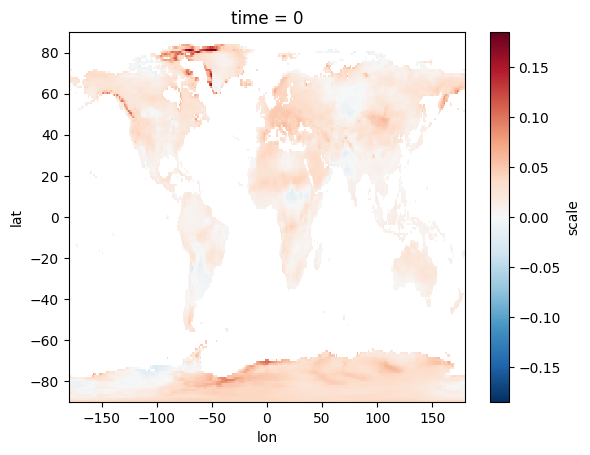

In [8]:
def k_to_c(image):
   return image.select().addBands(image.subtract(273.15))

def add_year_band(image):
   year = ee.Image(image.date().get('year')).rename('year').toFloat()
   return image.addBands(year)

july_deg_c = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
   .filterDate('1960', '2020')
   .filter(ee.Filter.calendarRange(7, None, 'month'))
   .select('temperature_2m')
   .map(k_to_c)
   .map(add_year_band))

coeff = july_deg_c.select(['year', 'temperature_2m']).reduce(
   ee.Reducer.linearFit())

ds = xarray.open_dataset(
   ee.ImageCollection([coeff]),
   engine='ee',
   scale=1,
   crs='EPSG:4326',
   geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

slope = ds['scale']
slope.transpose().plot()

#### Comparison

For calculating the July temperature trend slope, the server-side approach generally offers better performance due to the reduced data transfer (downloading one image vs. 720). While the client-side approach offers more flexibility with the full Python ecosystem and Xarray, this flexibility isn't necessary for this specific task. Code readability is comparable between the two approaches, with Xarray's `polyfit` being concise but Earth Engine's built-in functions also expressing the calculation clearly. Therefore, server-side computation is probably preferable in this case.

### Monthly mean temperature difference (July - January)

#### Client-side computation (using Xarray)

The client-side approach leverages the intuitive grouping capabilities of Xarray. We download the entire collection and use `groupby('time.month').mean(dim='time')` to efficiently calculate the monthly mean temperature. This approach provides a very clear and concise expression of the calculation.

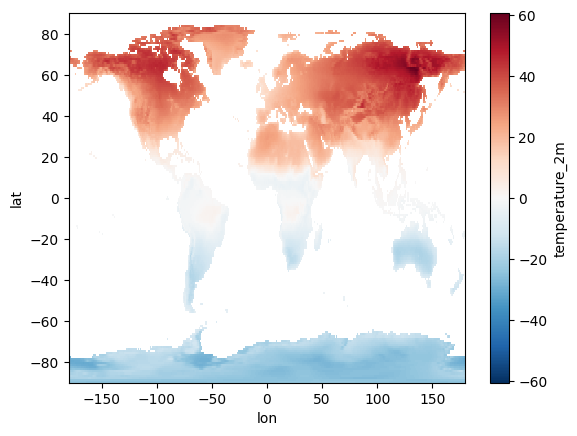

In [9]:
climate = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
   .filterDate('1960', '2020'))

ds = xarray.open_dataset(
   climate,
   engine='ee',
   scale=1,
   crs='EPSG:4326',
   geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

mean_deg_c = ds['temperature_2m'].groupby('time.month').mean(dim='time') - 273.15
(mean_deg_c[6] - mean_deg_c[0]).transpose().plot()

#### Server-side computation (using Earth Engine)

While Earth Engine can perform the calculation, it requires a join operation due to the need to group images by month. This involves creating helper functions and applying a join filter, which can be less intuitive compared to Xarray's concise grouping syntax.

/usr/local/lib/python3.11/dist-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


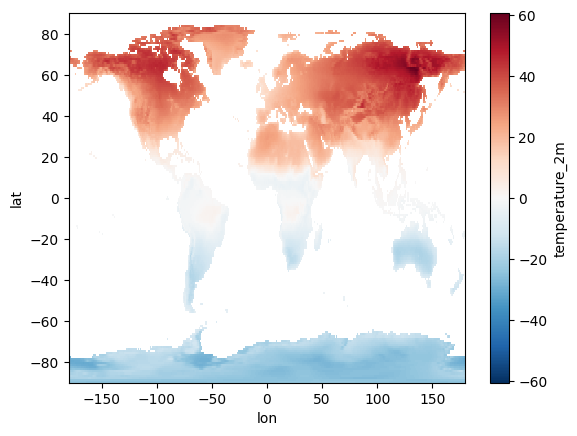

In [10]:
def k_to_c(image):
   return image.select().addBands(image.subtract(273.15))

def add_month_attribute(image):
   month = image.date().get('month')
   return image.set('month', month)

deg_c = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
   .filterDate('1960', '2020')
   .select('temperature_2m')
   .map(k_to_c)
   .map(add_month_attribute))

deg_c_by_month = deg_c.distinct('month')

filter = ee.Filter.equals(leftField='month', rightField='month')
join = ee.Join.saveAll('month_match')
deg_c_by_month = join.apply(deg_c_by_month, deg_c, filter)

def get_month_mean_across_years(image):
   deg_c_mean = ee.ImageCollection.fromImages(image.get('month_match')).mean()
   return deg_c_mean.set('month', image.get('month'))

deg_c_by_month = deg_c_by_month.map(get_month_mean_across_years)

ds = xarray.open_dataset(
   ee.ImageCollection(deg_c_by_month),
   engine='ee',
   scale=1,
   crs='EPSG:4326',
   geometry=ee.Geometry.Rectangle([-180, -90, 180, 90]),
)

mean_deg_c = ds['temperature_2m']
(mean_deg_c[6] - mean_deg_c[0]).transpose().plot()

#### Comparison

For calculating the monthly mean temperature difference with a focus on code readability, the client-side approach using Xarray is preferable. The grouping syntax is more natural and easier to follow. In situations where performance is a major concern (e.g., extremely large datasets or very high resolutions), the performance characteristics of each approach should be carefully evaluated, but in this case, the readability advantage of Xarray makes it a strong choice.